In [40]:
import pandas as pd
import os

lista_personaggi = ['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair']

folder_path = 'C:/Users/sollillo1/pythonProjects/fondamenti/Progetto_9/lfw_funneled/'

#definiamo una funzione per creare un DataFrame che fornisca dati sul sottoinsieme di interesse
def filter(file):
    file_name = os.path.join(folder_path, file)
    data = []

    try:
        with open(file_name, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    try:
                        personaggio, image_name = line.split('/')
                        if personaggio in lista_personaggi:
                            data.append([personaggio, image_name])
                    except ValueError:
                        print(f"Linea malformata in {file}:{line}")
    except FileNotFoundError:
        print(f"File non trovato: {file_name}")
    
    return pd.DataFrame(data, columns = ['Personaggio', 'Nome_immagine'])

#Consideriamo solo i file .txt che contengono informazioni sui personaggi del nostro sottoinsieme
files = ['pairs_01.txt', 'pairs_02.txt', 'pairs_03.txt', 'pairs_04.txt','pairs_05.txt','pairs_06.txt', 'pairs_07.txt','pairs_08.txt', 'pairs_09.txt', 'pairs_10.txt']

#Inseriamo i dati rilevanti ricavati da ciascun file in un unico dataframe
df_unico = pd.concat([filter(file) for file in files], ignore_index = True)

#Eliminiamo elementi duplicati 
df_unico.drop_duplicates(['Personaggio', 'Nome_immagine'], inplace=True)
#display(df_unico)

foto_pers = df_unico['Personaggio'].value_counts()

In [47]:
import numpy as np                
from matplotlib.image import imread 
import cv2

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_and_crop_face(gray_img):
    #rilevo i volti (l'immagine è già in scala di grigi)
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        #se nessun volto è rilevato, ritorna None
        return None
    
    #prendo il primo volto rilevato
    (x, y, w, h) = faces[0]
    cropped_face = gray_img[y:y+h, x:x+w]
    
    return cropped_face

subset_foto = []
#etichette per addestrare il modello 
personaggi_labels = []
nfaces_dict = {}

for personaggio in lista_personaggi:
    nfaces_dict[personaggio] = 0

for nome_cartella in os.listdir(folder_path): 
    percorso_cartella = os.path.join(folder_path, nome_cartella) #creiamo  il percorso completo alla cartella

    #ci accertiamo di accedere solo alle cartelle dei personaggi di interesse
    if os.path.isdir(percorso_cartella) and nome_cartella in lista_personaggi:
        #iteriamo attraverso le foto della cartella
        for file_name in os.listdir(percorso_cartella):
            file_path = os.path.join(percorso_cartella, file_name)
            #verifichiamo che il file a cui cerchiamo di accedere sia un'immagine e che non sia un duplicato
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                #utilizziamo imread per leggere l'immagine e caricarla in un array
                img = imread(file_path)
                #riduciamo le immagini a colori in scala di grigi calcolando la media dei valori della dimensione contenete i canali di colore
                #   print("Dimensione immagine a colori:", img.shape)
                img = np.mean(img , -1).astype(np.uint8)
                #   print("Dimensione immagine in scala di grigi:", img.shape)
                
                cropped_face = detect_and_crop_face(img)
                if cropped_face is not None:
                    #le immagini ritagliate possono avere diverse dimensoni 
                    resized_face =cv2.resize(cropped_face, (250,250))
                    #trasformo l'array multidimensionale dell'immagine appena aperta in un array unidimensionale
                    flattened_img = resized_face.flatten()
                    #   print("Dimensione appiattita:", flattened_img.shape)
                    subset_foto.append(flattened_img) 
                    personaggi_labels.append(nome_cartella)
                    nfaces_dict[nome_cartella] +=1


nfaces = []           
for personaggio in lista_personaggi:
    nfaces.append(nfaces_dict.get(personaggio, 0))

print("nfaces:", nfaces)
  
# X è la matrice di tutte le immagini appiattite, (250*250, N_immagini), ogni colonna rappresenta un'immagine
X = np.array(subset_foto).T
print(f"Dimensioni matrice di tutte le foto: {X.shape}")

nfaces: [77, 235, 121, 529, 109, 71, 144]
Dimensioni matrice di tutte le foto: (62500, 1286)


In [48]:
#dividere i dati di allenamento, valdation e test così come le etichette
from sklearn.model_selection import train_test_split
from collections import Counter

X = X.T
print(f"Dimensioni X:{X.shape}, (ogni riga rappresenta un'immagine)")

#conto quante immagini ci sono per ciascuna etichetta
label_counts = Counter(personaggi_labels)
print(label_counts)


X_train, X_test, y_train, y_test = train_test_split(
    X, personaggi_labels,
    test_size=0.1,
    random_state=42, 
    shuffle = True, 
    stratify  = personaggi_labels)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1,
    random_state=42, 
    shuffle = True, 
    stratify  = y_train)

print(f"Dimensioni training set: {X_train.shape}")  
print(f"Dimensioni validation set:{X_val.shape}")
print(f"Dimensioni test set: {X_test.shape}")  

Dimensioni X:(1286, 62500), (ogni riga rappresenta un'immagine)
Counter({'George_W_Bush': 529, 'Colin_Powell': 235, 'Tony_Blair': 144, 'Donald_Rumsfeld': 121, 'Gerhard_Schroeder': 109, 'Ariel_Sharon': 77, 'Hugo_Chavez': 71})
Dimensioni training set: (1041, 62500)
Dimensioni validation set:(116, 62500)
Dimensioni test set: (129, 62500)


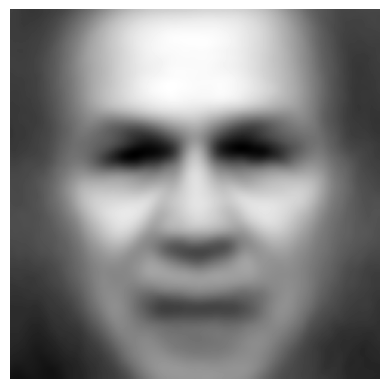

In [49]:
#calcolare il volto medio sull'insieme di addestramento
import matplotlib.pyplot as plt

avgFace = np.mean(X_train, axis = 0)

img_avg = plt.imshow(np.reshape(avgFace, (250,250)))
img_avg.set_cmap('gray')
plt.axis('off')
plt.show()

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

#sottrarre il volto medio agli insiemi per centrare i dati
X_train = X_train - avgFace

X_test = X_test - avgFace

X_val = X_val - avgFace


#normalizziamo i dati per migliorare la performance della SVM
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#eseguiamo la pca sulle prima 150 componenti
pca = PCA(n_components=150)

X_train_pca = pca.fit_transform(X_train)
print(f"Dimensioni training set dopo PCA: {X_train_pca.shape}")

X_val_pca = pca.transform(X_val)
print(f"Dimensioni validation set dopo PCA: {X_val_pca.shape}")

X_test_pca = pca.transform(X_test)
print(f"Dimensioni test set dopo PCA: {X_test_pca.shape}")

#creiamo il modello SVM
svm_model = SVC(kernel='rbf', class_weight='balanced', random_state = 42)

# Addestrare il modello SVM sull'intero training set e valutare sul validation set
svm_model.fit(X_train_pca, y_train)

#valutazione sul validation set
val_accuracy = svm_model.score(X_val_pca, y_val)
print(f"Accuratezza sul validation set: {val_accuracy*100:.2f}%")

test_accuracy = svm_model.score(X_test_pca, y_test)
print(f"Accuratezza sul test set: {test_accuracy*100:.2f}%")

Dimensioni training set dopo PCA: (1041, 150)
Dimensioni validation set dopo PCA: (116, 150)
Dimensioni test set dopo PCA: (129, 150)
Accuratezza sul validation set: 80.17%
Accuratezza sul test set: 76.74%


In [45]:
from sklearn.model_selection import GridSearchCV

#elenchiamo i parametri da testare
param_grid = {
    'C': [0.1, 1.0, 10, 20, 50, 100, 1000],
    'gamma': ['auto', 'scale']
}

# k-fold cross validation con k = 5
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy') 

#addestro GridSearchCV
grid_search.fit(X_train_pca, y_train)

#inserisco i risultati in un DataFrame ed estraggo solo quelli di interesse
grid_search.cv_results_
result = pd.DataFrame(grid_search.cv_results_)
display(result[['param_C', 'param_gamma', 'mean_test_score']])

#controllo i migliori parametri trovati
best_params = grid_search.best_params_
print(f"Migliori parametri trovati: {best_params}")

#addestro il modello SVM con i migliori parametri
best_svm_model = grid_search.best_estimator_

#valuto il modello ottimizzato sul validation set
val_accuracy_opt = best_svm_model.score(X_val_pca, y_val)
print(f"Accuratezza sul validation set con ottimizzazione: {val_accuracy_opt * 100:.2f}%")

#valuto il modello ottimizzato sul test set
test_accuracy_opt = best_svm_model.score(X_test_pca, y_test)
print(f"Accuratezza sul test set con ottimizzazione: {test_accuracy_opt * 100:.2f}%")

,param_C,param_gamma,mean_test_score
0,0.1,auto,0.121099
1,0.1,scale,0.303602
2,1.0,auto,0.228450
3,1.0,scale,0.751228
4,10,auto,0.411143
5,10,scale,0.786755
6,20,auto,0.411143
7,20,scale,0.787716
8,50,auto,0.411143
9,50,scale,0.787716


Migliori parametri trovati: {'C': 20, 'gamma': 'scale'}
Accuratezza sul validation set con ottimizzazione: 84.48%
Accuratezza sul test set con ottimizzazione: 80.62%
